In [ ]:
import yfinance as yf
import pandas as pd
from scipy.optimize import minimize
import numpy as np
import datetime

In [ ]:
#tickers = ['SPY','BND','GLD','QQQ','VTI']

tickers = ['HDFCBANK.NS','ZOMATO.NS', 'BHARTIARTL.NS','ITC.NS']

In [ ]:
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=365)

In [ ]:
close_price = yf.download(tickers, start=start_date, end=end_date)['Close']

[*********************100%***********************]  4 of 4 completed


In [ ]:
log_return = np.log(close_price / close_price.shift(1))
log_return = log_return.dropna()

In [ ]:
cov_matrix = log_return.cov()*252
print(cov_matrix)

Ticker         BHARTIARTL.NS  HDFCBANK.NS    ITC.NS  ZOMATO.NS
Ticker                                                        
BHARTIARTL.NS       0.056562     0.011764  0.013930   0.009362
HDFCBANK.NS         0.011764     0.043558  0.007609   0.025062
ITC.NS              0.013930     0.007609  0.039853   0.014668
ZOMATO.NS           0.009362     0.025062  0.014668   0.177889


In [ ]:
def standard_deviation(weight, cov_matrix):
  variance = weight.T @ cov_matrix @ weight
  return np.sqrt(variance)

In [ ]:
def expected_return(weight, log_return):
  return np.sum(log_return.mean() * 252 * weight)

In [ ]:
def sharp_ratio(weight, log_return, cov_matrix, risk_free_rate):
  return (expected_return(weight, log_return) - risk_free_rate) / standard_deviation(weight, cov_matrix)

In [ ]:
!pip install fredapi

In [ ]:
# from fredapi import Fred

# fred = Fred(api_key = "API")
# ten_year_treasury_rate = fred.get_series_latest_release('GS10')/100

# risk_free_rate = ten_year_treasury_rate.iloc[-1]
# print(risk_free_rate)

risk_free_rate = 0.0644

In [ ]:
def negetive_sharp_ratio(weight, log_return, cov_matrix, risk_free_rate):
  return -sharp_ratio(weight, log_return, cov_matrix, risk_free_rate)

In [ ]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.4) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

optimized_results = minimize(negetive_sharp_ratio, initial_weights, args=(log_return, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [ ]:
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_return)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharp_ratio(optimal_weights, log_return, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
HDFCBANK.NS: 0.4000
ZOMATO.NS: 0.4000
BHARTIARTL.NS: 0.1284
ITC.NS: 0.0716
Expected Annual Return: 0.2449
Expected Volatility: 0.1606
Sharpe Ratio: 1.1234


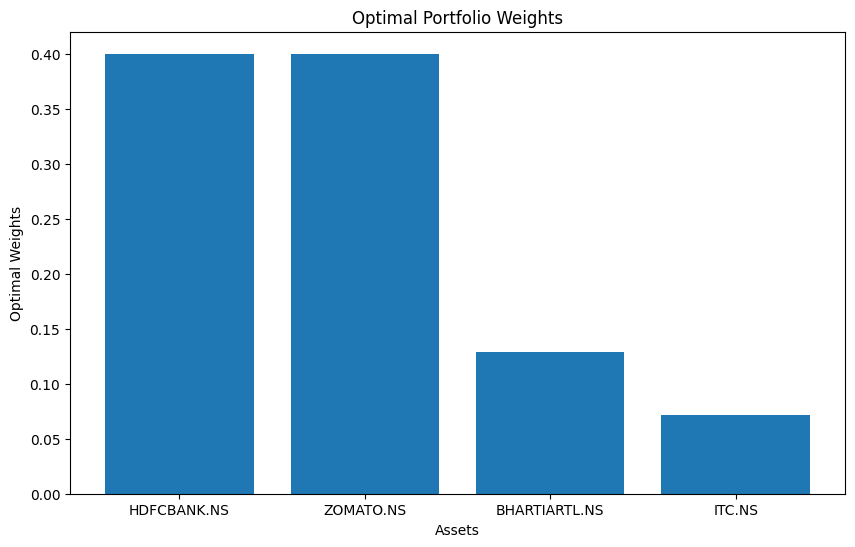

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()